In [1]:
import numpy as np
import sys
from pyinstrument import Profiler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from bart_playground import *
import bartz

In [2]:
proposal_probs = {"grow" : 0.5,
                  "prune" : 0.5}
generator = DataGenerator(n_samples=160, n_features=2, noise=0.1, random_seed=42)
X, y = generator.generate(scenario="piecewise_flat")
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

print(y_train)

[ 2.00327821  2.10672224  1.76898966  2.05211673  2.00693811  2.16162097
 -0.14127659  2.15112284  1.03487759  1.23276531  1.94055996  1.88216964
  2.08418201  2.04593858  2.08279882  1.87834399  0.83987221  1.96685118
  2.0928297   2.1475949   1.17439345  0.13206617  1.77087105  1.93949993
  1.98107557  1.97948383  2.09895839  1.96062588  2.13276861  2.05826552
  0.17207698  2.13535859  1.0856794   0.94290563  2.07019536  1.93288597
  1.84184056  2.00921267 -0.10137174  1.06375338  1.96419833  2.05241878
  2.05909063  1.01967761  0.88826159  1.79270166  0.03619219  2.0232878
  2.03139082  1.08443852  2.13095507  2.03043667  1.86178185  2.0803585
  1.81690942  1.00114261  1.97068084  2.10762402  1.91666312  2.03833939
  2.04389932  1.9154339   1.98689133  2.02703432  1.04138903  2.02762742
  1.92058637  1.00720336  2.10684716  0.9703429   2.0846584   2.16042544
  1.89594561  1.99308621  1.92953267  2.00543536  1.19510126  2.20769805
  2.02292114  1.00665458  0.91626018  0.98093489  1.9

In [3]:
# profiler = Profiler()
# profiler.start()
bart = DefaultBART(ndpost=500, nskip=100, n_trees=100, proposal_probs=proposal_probs)
bart.fit(X_train, y_train)
# profiler.stop()
# profiler.print()

Running iteration 0
Running iteration 10
Running iteration 20
Running iteration 30
Running iteration 40
Running iteration 50
Running iteration 60
Running iteration 70
Running iteration 80
Running iteration 90
Running iteration 100
Running iteration 110
Running iteration 120
Running iteration 130
Running iteration 140
Running iteration 150
Running iteration 160
Running iteration 170
Running iteration 180
Running iteration 190
Running iteration 200
Running iteration 210
Running iteration 220
Running iteration 230
Running iteration 240
Running iteration 250
Running iteration 260
Running iteration 270
Running iteration 280
Running iteration 290
Running iteration 300
Running iteration 310
Running iteration 320
Running iteration 330
Running iteration 340
Running iteration 350
Running iteration 360
Running iteration 370
Running iteration 380
Running iteration 390
Running iteration 400
Running iteration 410
Running iteration 420
Running iteration 430
Running iteration 440
Running iteration 450

In [4]:
arrays = [tree.vars for tree in bart.trace[-1].trees]
counts = np.array([np.count_nonzero(arr >= 0) for arr in arrays])
print(counts)
deep_trees = np.array([count >= 3 for count in counts])
print(np.where(deep_trees))

[0 0 1 0 0 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 2 0 0 0 0 1 1 0 1 1 0 1 0 0 2 0 1 1 0 0 0 2 2 1 3 1 0 0 1 0 1 0 2 1 4 1 1
 1 1 0 1 2 1 1 1 1 1 1 0 1 0 0 1 3 0 0 0 1 0 1 1 0 0]
(array([61, 71, 90], dtype=int64),)


X_1 <= 0.571 (split, n = 120)
	Val: 0.011 (leaf, n = 68)
	Val: -0.007 (leaf, n = 52)
[ 1 -1 -1 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2 -2]
[-0.05638511  0.01136208 -0.00694931  0.00215448 -0.00918338 -0.05508977
 -0.09095192 -0.00449434  0.00384977  0.05150366 -0.02951537  0.03430578
  0.00243315         nan         nan         nan]


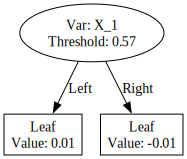

In [5]:
from bart_playground import visualize_tree
tree_sp : Tree = bart.sampler.trace[-1].trees[73]

print(tree_sp)
print(tree_sp.vars)
print(tree_sp.leaf_vals)
# print(tree_sp.node_indicators)
visualize_tree(tree_sp, tree_sp)

In [6]:
rf = RandomForestRegressor()
lr = LinearRegression()
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=100, ndpost=200, nskip=100)
btpred_all = btz.predict(np.transpose(X_test))
btpred = np.mean(np.array(btpred_all), axis=0)

Iteration 100/300 P_grow=0.56 P_prune=0.44 A_grow=0.30 A_prune=0.36 (burnin)
Iteration 200/300 P_grow=0.57 P_prune=0.43 A_grow=0.37 A_prune=0.49
Iteration 300/300 P_grow=0.57 P_prune=0.43 A_grow=0.37 A_prune=0.40


In [7]:
models = {"bart" : bart, 
          "rf" : rf, 
          "lr" : lr,
          "btz" : btz}
results = {}
for model_name, model in models.items():
    if model_name == "btz":
        results[model_name] = mean_squared_error(y_test, btpred)
    else:
        results[model_name] = mean_squared_error(y_test, model.predict(X_test))
results

{'bart': 0.1479261173286847,
 'rf': 0.037581446268720384,
 'lr': 0.16526245493311217,
 'btz': 0.05354455956502713}

In [ ]:
print(bart.sampler.trace[600].evaluate(X_test))
print(y_test)
for i in range(100):
    mse_i = mean_squared_error(y_test, bart.trace[i].evaluate(X_test))
    # print(mse_i)

[ 0.48151805  0.19982685  0.50850674  0.23355405  0.3273954   0.3121246
 -0.08029147  0.54329974 -0.20998965  0.35864415  0.40752257  0.31668935
  0.19274701  0.19982685  0.634087    0.63661315  0.03630411  0.49099286
  0.24448608  0.3121246   0.08106725 -0.31359774  0.46346747  0.3803551
  0.2186489   0.3831886   0.33007574  0.28147442  0.48437207  0.441694
 -0.19284792  0.70973796  0.13935514  0.02418349  0.33226121  0.3030549
  0.51724176  0.33226121 -0.24562501  0.22643667  0.49099286  0.5810064
  0.67881021  0.18725895  0.17560548  0.39530973 -0.62114945  0.22889134
  0.43549548  0.206262    0.19982685  0.46325462  0.54329974  0.50759167
  0.634087   -0.26714955  0.56817049  0.37985142  0.255714    0.25419637
  0.39964675  0.38559311  0.3391752   0.30939979  0.27178967  0.24437852
  0.38335287 -0.04093167  0.34354632  0.23993823  0.46603355  0.36414045
  0.57291173  0.26462891  0.29912554  0.54329974  0.30779618  0.18611622
  0.53372927  0.08444666 -0.13690302  0.04694511  0.32757

In [10]:
mean_squared_error(y_test, np.ones_like(y_test) * y_test.mean())

0.39781114029234965

In [21]:
# print(bart.sampler.trace[600].evaluate())
# print(bart.sampler.trace[600].evaluate(X_train))

if all([(bart.sampler.trace[600].trees[i].evaluate() == bart.sampler.trace[600].trees[i].evaluate(X_train)).all()
        for i in range(100)]):
    print("True")
else:
    print("False")

False
